#  Preparing Data

In [1]:
from sklearn.datasets import fetch_mldata 
data=fetch_mldata('MNIST original')

In [2]:
X, y = data["data"], data["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [3]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] 

In [4]:
X_train.shape

(60000, 784)

# Model Specification

In [4]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB

model_sgd=SGDClassifier(max_iter=5, tol=None)
model_sgd.fit(X_train, y_train)

model_ridge=RidgeClassifier()
model_ridge.fit(X_train, y_train)

model_bern=BernoulliNB()
model_bern.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

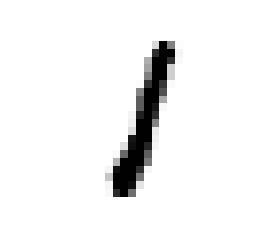

Accuracy on the test set [SGDC, Naive Bayes, Ridge]: 0.865300 0.841300 0.860300


In [5]:
import matplotlib
import matplotlib.pyplot as plt 
def plot_mnist(var):
    im=var.reshape(28,28)
    plt.imshow(im, cmap = matplotlib.cm.binary,
           interpolation="nearest")
    plt.axis("off")
    plt.show()
test=X[12500]

plot_mnist(test)
result_sgd=model_sgd.predict(X_test)
sgd = result_sgd==y_test
a=sum(sgd)/len(sgd)

result_nb=model_bern.predict(X_test)
nb = result_nb==y_test
b=sum(nb)/len(nb)

result_ridge=model_ridge.predict(X_test)
ridge = result_ridge==y_test
c=sum(ridge)/len(ridge)

print('Accuracy on the test set [SGDC, Naive Bayes, Ridge]: %3.6f %3.6f %3.6f'% (a, b, c))

SGD seemed to have the best accuracy with default settings, while a Bernoulli Naive Bayes performed worst. At first I thought it was because a Bernoulli assumption was insufficient to capture the real distributions of the 28x28 feature space, but experimenting with Gaussian distribution yielded even worst results. Clearly, this indicates the features are not independent, which is to be expected since grayscale pixels of handwritten digits are quite predictable and correlated. Experimentation with further exploration of settings for SGD is below. 

# SGD

In [8]:
l=[]
r=[]
for i in range(25): 
    model_sgd=SGDClassifier(max_iter=5, tol=None)
    model_sgd.fit(X_train, y_train)
    result_sgd=model_sgd.predict(X_test)
    sgd = result_sgd==y_test
    l.append(sum(sgd)/len(sgd))
    result_s=model_sgd.predict(X_train)
    s = result_s==y_train
    r.append(sum(s)/len(s))

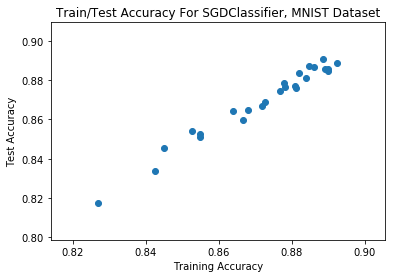

In [9]:
import matplotlib.pyplot as plt
plt.scatter(r,l)
plt.xlabel('Training Accuracy')
plt.ylabel('Test Accuracy')
plt.title('Train/Test Accuracy For SGDClassifier, MNIST Dataset')
plt.show()

In [10]:
SGD=SGDClassifier(loss='log', penalty='l1', alpha=0.001, max_iter=5, tol=None)
SGD.fit(X_train, y_train)
result_sgd=SGD.predict(X_test)
sgd = result_sgd==y_test
a=sum(sgd)/len(sgd)
print('Adjusted SGD accuracy:',a)

Adjusted SGD accuracy: 0.9027


In [11]:
from sklearn.model_selection import cross_val_score, cross_val_predict
x=cross_val_score(SGD,X_train,y_train, cv=3, scoring='accuracy')
print("3-fold cross validation accuracy on train set:", x)

3-fold cross validation accuracy on train set: [ 0.89412118  0.8899945   0.88843326]


In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score
pred=cross_val_predict(SGD,X_train,y_train, cv=3)
mat=confusion_matrix(y_train, pred)
print('Precision scores for each class: \n ',precision_score(y_train,pred,average=None))
print('Recall scores for each class: \n ',recall_score(y_train,pred,average=None))
print('Confusion Matrix for each class \n')

Precision scores for each class: 
  [ 0.94167498  0.9534608   0.9028522   0.88155922  0.91195295  0.8490566
  0.93552189  0.92359987  0.76585736  0.86762936]
Recall scores for each class: 
  [ 0.95677866  0.9541679   0.87663646  0.86315446  0.90243067  0.80520199
  0.93899966  0.91077414  0.86258759  0.84837788]
Confusion Matrix for each class 



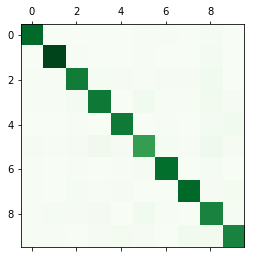

,0,1,2,3,4,5,6,7,8,9
0,5667,0,18,18,8,32,43,7,121,9
1,3,6433,48,25,9,38,11,10,151,14
2,39,42,5223,106,84,45,85,74,238,22
3,37,43,162,5292,9,237,29,49,205,68
4,16,19,35,17,5272,15,41,19,173,235
5,95,33,58,262,82,4365,124,29,279,94
6,34,15,45,11,41,88,5557,12,106,9
7,45,19,101,46,58,15,11,5706,66,198
8,43,111,72,138,24,238,36,21,5047,121
9,39,32,23,88,194,68,3,251,204,5047


In [13]:
plt.matshow(mat, cmap=plt.cm.Greens)
plt.show()
pd.DataFrame(mat)

# Ensemble Model: Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion='entropy')
RF.fit(X_train,y_train)
results_rf=RF.predict(X_test)
rf=results_rf==y_test
print('Accuracy for adjusted random forest without pruning:',sum(rf)/len(rf))

Accuracy for adjusted random forest without pruning: 0.9483


In [15]:
#Varying forest trees
import matplotlib.pyplot as plt

empty_1=[]
empty_2=[]
for _ in range(1,15): 
    RF_1=RandomForestClassifier(criterion='entropy', n_estimators=_)
    RF_1.fit(X_train,y_train)
    results_rf_1=RF_1.predict(X_test)
    rf_1=results_rf_1==y_test
    me_1=sum(rf_1)/len(rf_1)
    empty_1.append(me_1)
    RF_2=RandomForestClassifier(criterion='gini', n_estimators=_)
    RF_2.fit(X_train,y_train)
    results_rf_2=RF_2.predict(X_test)
    rf_2=results_rf_2==y_test
    me_2=sum(rf_2)/len(rf_2)
    empty_2.append(me_2)

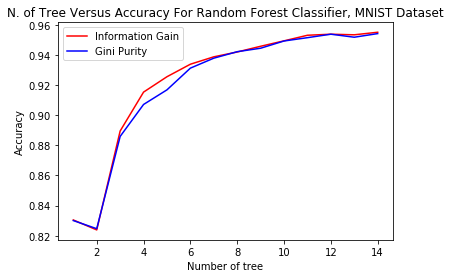

In [16]:
ash1, =plt.plot([_ for _ in range(1,15)], empty_1, "red")
ash2, =plt.plot([_ for _ in range(1,15)], empty_2, "blue")
plt.xlabel('Number of tree')
plt.ylabel('Accuracy')
plt.title('N. of Tree Versus Accuracy For Random Forest Classifier, MNIST Dataset')
plt.legend([ash1, ash2], ['Information Gain', 'Gini Purity'])
plt.show()

The fact that a non-linear model such as Random Forest outperform linear model like Naive Bayes or Ridge Regression indicates somewhat that the space is non-linear. 

In [17]:
pred_rf=cross_val_predict(RF,X_train,y_train, cv=3)
mat_rf=confusion_matrix(y_train, pred_rf)
print('Precision scores for each class: \n ',precision_score(y_train,pred_rf,average=None))
print('Recall scores for each class: \n ',recall_score(y_train,pred_rf,average=None))
print('Confusion Matrix for each class \n')

Precision scores for each class: 
  [ 0.9594438   0.9708553   0.92259859  0.9198044   0.93214646  0.92854464
  0.96144132  0.95761079  0.94286735  0.92985766]
Recall scores for each class: 
  [ 0.97855816  0.98323939  0.9462907   0.9204045   0.95001712  0.91330013
  0.96485299  0.95195531  0.90258076  0.91141368]
Confusion Matrix for each class 



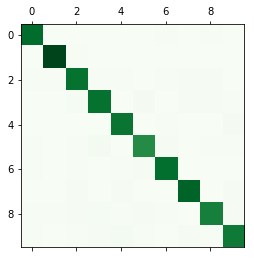

,0,1,2,3,4,5,6,7,8,9
0,5796,3,17,9,6,24,28,2,34,4
1,1,6629,38,12,10,12,7,14,13,6
2,44,32,5638,42,32,8,35,59,55,13
3,19,23,130,5643,9,132,4,59,72,40
4,21,13,22,11,5550,5,44,17,15,144
5,43,23,29,191,25,4951,57,8,47,47
6,41,15,28,3,37,64,5710,1,17,2
7,12,26,88,18,54,6,2,5964,15,80
8,32,48,86,119,51,95,45,21,5281,73
9,32,16,35,87,180,35,7,83,52,5422


In [18]:
plt.matshow(mat_rf, cmap=plt.cm.Greens)
plt.show()
pd.DataFrame(mat_rf)

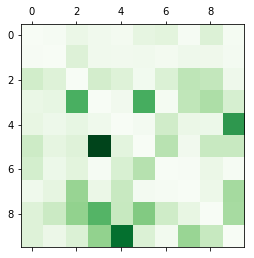

In [19]:
#Error plot
import numpy as np 
error=mat_rf/mat_rf.sum(axis=1, keepdims=True)
np.fill_diagonal(error,0)
plt.matshow(error, cmap=plt.cm.Greens)
plt.show()

The RF classifier seems to mistakenly classify 3s as 5s and vice versa the most, as well as 4s and 9s. 

In [20]:
X_33=X_train[(y_train==3) & (pred_rf==3)]
X_55=X_train[(y_train==5) & (pred_rf==5)]
X_35=X_train[(y_train==3) & (pred_rf==5)]
X_53=X_train[(y_train==5) & (pred_rf==3)]


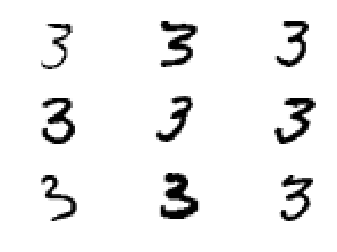

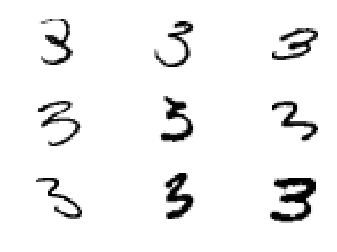

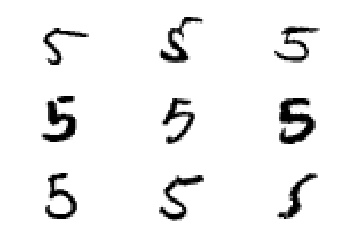

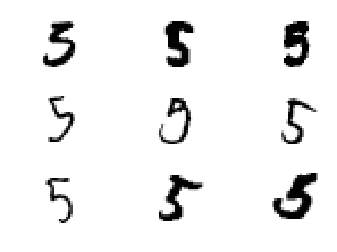

In [21]:
def plot_digits(x,y,data): 
    for _ in range(len(data)):
        plt.subplot(x, y, _+1)
        im=data[_].reshape(28,28)
        plt.imshow(im, cmap = matplotlib.cm.binary, interpolation="nearest")
        plt.axis("off")
    plt.show()

plot_digits(3,3, X_33[:9])
plot_digits(3,3, X_35[:9])
plot_digits(3,3, X_55[:9])
plot_digits(3,3, X_53[:9])

# GridSearch: RandomForest

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

paras=[{'n_estimators':[10, 15, 20], 'criterion':["gini", "entropy"], 
        'max_features':["sqrt","log2", None], 'max_depth':[3,4,5]}]

RF_search=RandomForestClassifier()
grid_search = GridSearchCV(RF_search, paras, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 .
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 .
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 .
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=15 .
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, total=   2.4s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=15 .
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, total=   2.4s
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, total=   2.5s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=15 .
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=20 .
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=15, total=   3.3s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=20 .
[CV]  criterion=gini, max_dept

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min


[CV]  criterion=gini, max_depth=4, max_features=log2, n_estimators=10, total=   0.8s
[CV] criterion=gini, max_depth=4, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=4, max_features=log2, n_estimators=10, total=   1.0s
[CV] criterion=gini, max_depth=4, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=4, max_features=sqrt, n_estimators=20, total=   3.5s
[CV] criterion=gini, max_depth=4, max_features=log2, n_estimators=15 .
[CV]  criterion=gini, max_depth=4, max_features=log2, n_estimators=10, total=   1.0s
[CV] criterion=gini, max_depth=4, max_features=log2, n_estimators=15 .
[CV]  criterion=gini, max_depth=4, max_features=log2, n_estimators=15, total=   1.2s
[CV] criterion=gini, max_depth=4, max_features=log2, n_estimators=15 .
[CV]  criterion=gini, max_depth=4, max_features=log2, n_estimators=15, total=   1.3s
[CV] criterion=gini, max_depth=4, max_features=log2, n_estimators=20 .
[CV]  criterion=gini, max_depth=4, max_features=log2, n_estimato

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.7min


[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=10, total= 1.1min
[CV] criterion=entropy, max_depth=5, max_features=None, n_estimators=15 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=10, total= 1.1min
[CV] criterion=entropy, max_depth=5, max_features=None, n_estimators=20 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=15, total= 1.5min
[CV] criterion=entropy, max_depth=5, max_features=None, n_estimators=20 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=15, total= 1.5min
[CV] criterion=entropy, max_depth=5, max_features=None, n_estimators=20 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=15, total= 1.5min
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=20, total= 1.9min
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=20, total= 1.6min
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=20, total= 1.4min


[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 18.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [10, 15, 20], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2', None], 'max_depth': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [13]:
print('Best parameter combination found:', grid_search.best_params_)
print('Best accuracy found:', grid_search.best_score_)

Best parameter combination found: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 20}
Best accuracy found: 0.833766666667


This diminishing of accuracy is probably because of limiting the depth of trees (pruning). 

# Multilabel Classifier

In [22]:
label_1= (y_train <= 6)
label_2= (y_train % 2 == 0)
label_3= (y_train % 3 ==0)
label= np.c_[label_1,label_2,label_3]

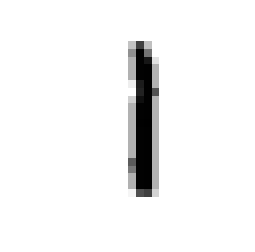

array([[ True, False, False]], dtype=bool)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

KNN=KNeighborsClassifier(p=2)
KNN.fit(X_train, label)
test_1=X_train[34567]
plot_mnist(test_1)
KNN.predict([test_1])

# Noise Filtering

In [24]:
import numpy as np
noise=np.random.randint(0, 100, (len(X_train), 28*28) )
noisy=X_train+noise
clean=X_train 
clean_model=KNeighborsClassifier(p=2)
clean_model.fit(noisy, clean)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

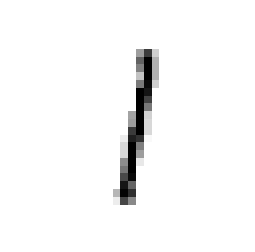

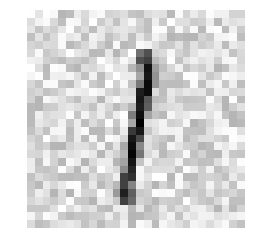

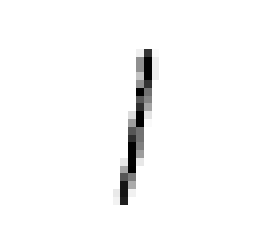

In [25]:
im1=noisy[32456]
im2=clean_model.predict([im1])
plot_mnist(X_train[32456])
plot_mnist(im1)
plot_mnist(im2)